# Inspiration

- Basic Keras implementation: https://www.kaggle.com/bguberfain/naive-keras

- High-level image segmentation example: https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split


In [11]:
input_folder = join('input')

df_mask = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

print("There are %d unique images and %d unique cars" % (len(df_mask),len(ids_train)))

There are 5088 unique images and 318 unique cars


In [91]:
load_img = lambda im, idx: imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [26]:
print("Dimension of each image is", load_img(ids_train[0], 1).shape)

Dimension of each image is (1280, 1918, 3)


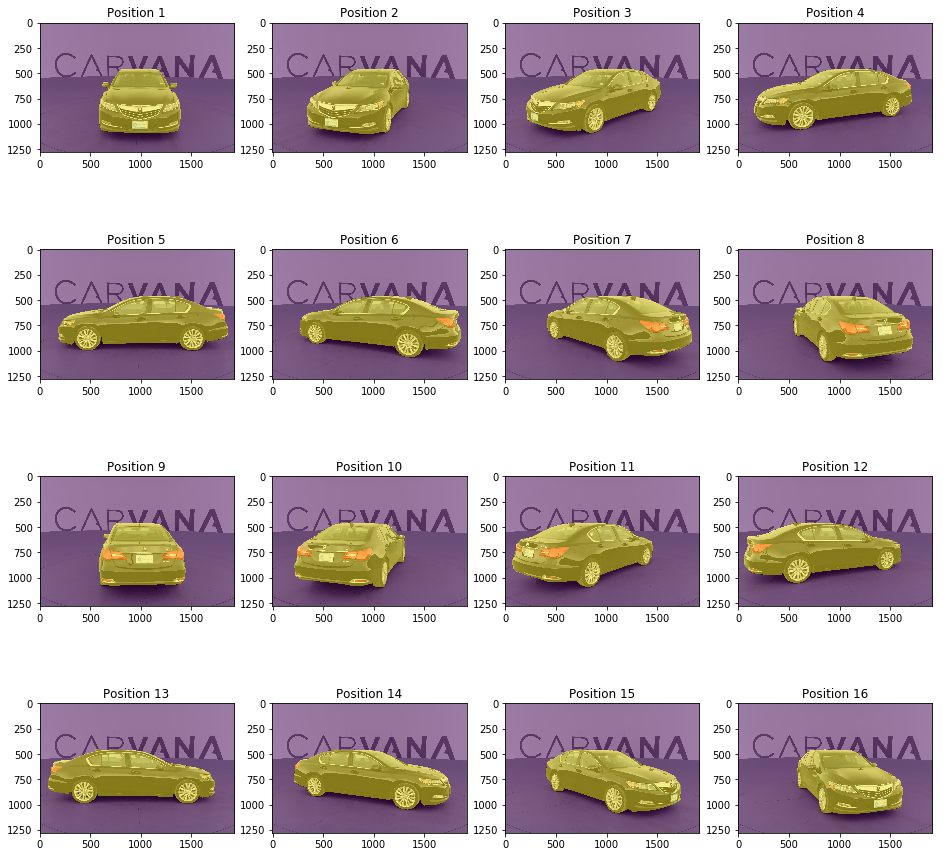

In [40]:
# Let's display a single car and mask

fig, ax = plt.subplots(4,4, figsize=(16, 16))
ax = ax.ravel()

for i in imgs_idx:
    ax[i-1].imshow(load_img(ids_train[0], i))
    ax[i-1].imshow(load_mask(ids_train[0], i), alpha = 0.5)
    ax[i-1].set_title('Position {}'.format(i))


In [27]:
# Seems like there is a lot of rotational symmetry e.g. #2 and #17, 
# although the pictures are not exact copies of each other (you can see from the background text)

In [3]:
# Create simple model
from keras.layers import Conv2D
from keras.models import Sequential
import keras.backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
num_train = 32  # len(ids_train)

# Load data for position id=1
X = np.empty((num_train, 320, 480, 12), dtype=np.float32)
y = np.empty((num_train, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        del imgs_id # Free memory
        bar.update()

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Concat overall y info to X
# This is important as the kernels of CNN used below has no information of its location
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_min = y_train.min(axis=0)

y_features = np.concatenate([y_train_mean, y_train_std, y_train_min], axis=2)

X_train[:, ..., -3:] = y_features
X_val[:, ..., -3:] = y_features

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


In [30]:
# Normalize input and output
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

In [31]:
# Create simple model
from keras.layers import Conv2D
from keras.models import Sequential
import keras.backend as K

model = Sequential()
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 12) ) )
model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

In [135]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 480, 16)      1744      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 480, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 320, 480, 1)       801       
Total params: 7,185
Trainable params: 7,185
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=5, verbose=2)

Train on 25 samples, validate on 7 samples
Epoch 1/15
 - 31s - loss: -1.6721e-01 - acc: 0.7411 - dice_coef: 0.4024 - val_loss: -3.1001e-01 - val_acc: 0.7932 - val_dice_coef: 0.5017
Epoch 2/15
 - 25s - loss: -4.1006e-01 - acc: 0.8328 - dice_coef: 0.5701 - val_loss: -4.9600e-01 - val_acc: 0.9141 - val_dice_coef: 0.6215
Epoch 3/15
 - 24s - loss: -5.8457e-01 - acc: 0.9345 - dice_coef: 0.6777 - val_loss: -6.5449e-01 - val_acc: 0.9398 - val_dice_coef: 0.7304
Epoch 4/15
 - 28s - loss: -7.0746e-01 - acc: 0.9443 - dice_coef: 0.7789 - val_loss: -7.3268e-01 - val_acc: 0.9410 - val_dice_coef: 0.8106
Epoch 5/15
 - 27s - loss: -7.7340e-01 - acc: 0.9522 - dice_coef: 0.8377 - val_loss: -7.7906e-01 - val_acc: 0.9534 - val_dice_coef: 0.8444
Epoch 6/15
 - 33s - loss: -7.9822e-01 - acc: 0.9588 - dice_coef: 0.8618 - val_loss: -7.8967e-01 - val_acc: 0.9563 - val_dice_coef: 0.8622
Epoch 7/15
 - 36s - loss: -8.1032e-01 - acc: 0.9609 - dice_coef: 0.8765 - val_loss: -8.0564e-01 - val_acc: 0.9597 - val_dice_coef

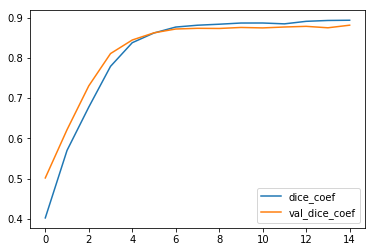

In [34]:
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()

In [56]:
x.shape

(320, 480, 12)

In [115]:
x.shape

(320, 480, 12)

Text(0.5,1,'y_pred')

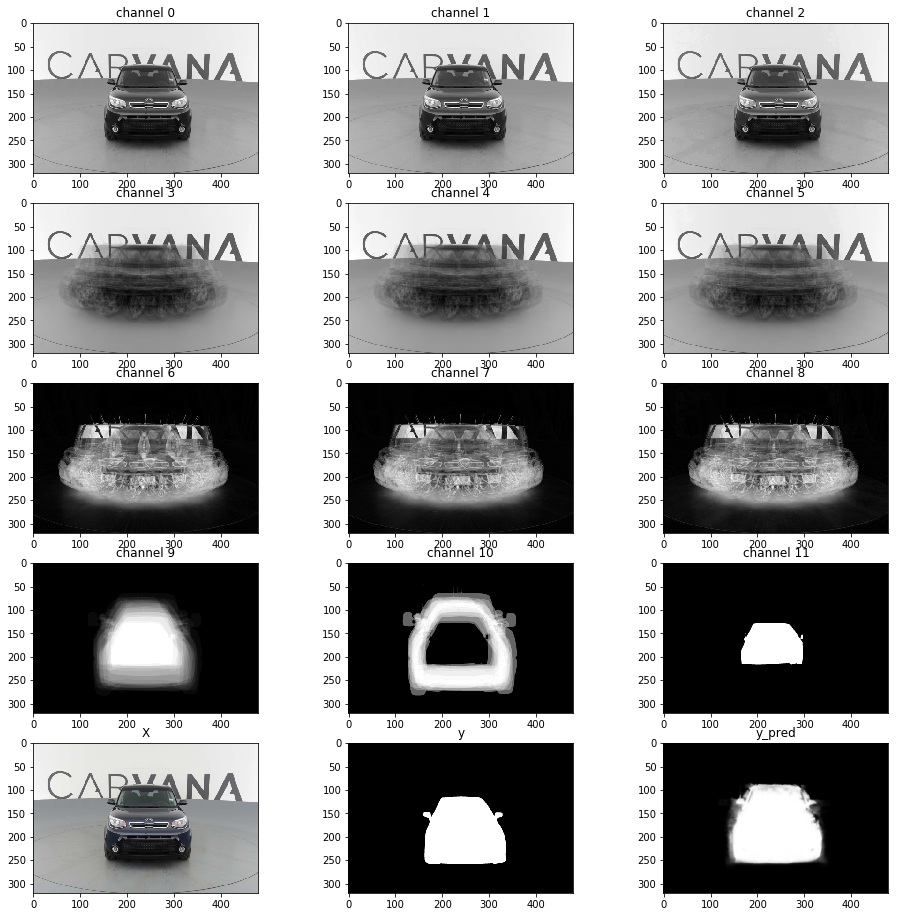

In [114]:
idx = 0
x = X_val[idx]

fig, ax = plt.subplots(5,3, figsize=(16, 16))
ax = ax.ravel()

cmaps = ['Reds', 'Greens', 'Blues']
for i in range(x.shape[-1]):
    ax[i].imshow(x[...,i], cmap='gray') #cmaps[i%3])
    ax[i].set_title('channel {}'.format(i))

ax[-3].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255.)
ax[-3].set_title('X')

ax[-2].imshow(y_train[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

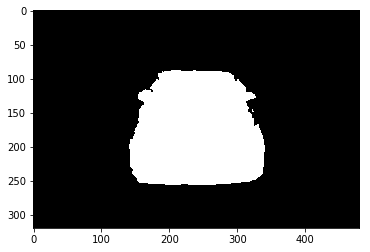

In [41]:
plt.imshow(y_pred > 0.5, cmap='gray')

In [42]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

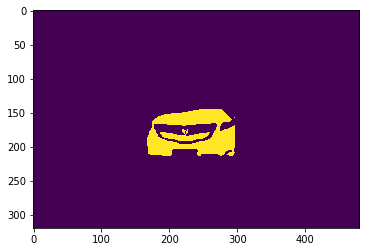

In [218]:
res = np.where(y_pred > 0.5, 1, 0)

res2 = rle_encode(res)
plt.imshow(rle_decode(res2, (320, 480)))

In [80]:
df_mask = pd.read_csv(join(input_folder, 'sample_submission.csv'), usecols=['img'])
ids_test = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

print("There are %d unique images and %d unique cars in the test set" % (len(df_mask),len(ids_test)))

There are 100064 unique images and 6254 unique cars in the test set


In [74]:
ids_test[1]

'000aa097d423'

In [180]:
# Something is funny here
load_test_img = lambda im, idx: imread(join(input_folder, 'test', '{}_{:02d}.jpg'.format(im, idx)))

imgs_idx = list(range(1, 17))

def prepare_img(im, idx):
    
    X = np.empty((320, 480, 12), dtype=np.float32)
    imgs_id = [resize(load_test_img(im, j)) for j in imgs_idx]
    X[... ,:9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
    
    X -= X_mean.squeeze()
    X /= X_std.squeeze()
    X[...,9:] = y_features

    return(X)
    
def predict_img(X):

    y_pred = model.predict(X[None]).squeeze()
    res = np.where(y_pred > 0.5, 1, 0)
    return rle_encode(res)


In [224]:
# Something is funny here
load_test_img = lambda im, idx: imread(join(input_folder, 'test', '{}_{:02d}.jpg'.format(im, idx)))

imgs_idx = list(range(1, 17))

def prepare_img(im):
    
    X = np.empty((16, 320, 480, 12), dtype=np.float32)
    imgs_id = [resize(load_test_img(im, j)) for j in imgs_idx]
    
    means = np.mean(imgs_id, axis=0)
    stds = np.std(imgs_id, axis=0)
    
    #print(means.shape, stds.shape, imgs_id[0].shape)
    
    for i in imgs_idx:
        X[i-1, ...,:9] = np.concatenate([imgs_id[i-1], means, stds], axis = 2)
    
    X -= X_mean.squeeze()
    X /= X_std.squeeze()
    X[...,9:] = y_features

    #print(X.shape)
    
    return(X.squeeze())
    
def predict_img(X):

    y_pred = model.predict(X).squeeze()
    res = []
    for x in y_pred:
        res.append(rle_encode(np.where(x > 0.5, 1, 0)))
    return res


In [ ]:
X = prepare_img(ids_test[0])
y_pred = model.predict(X).squeeze()

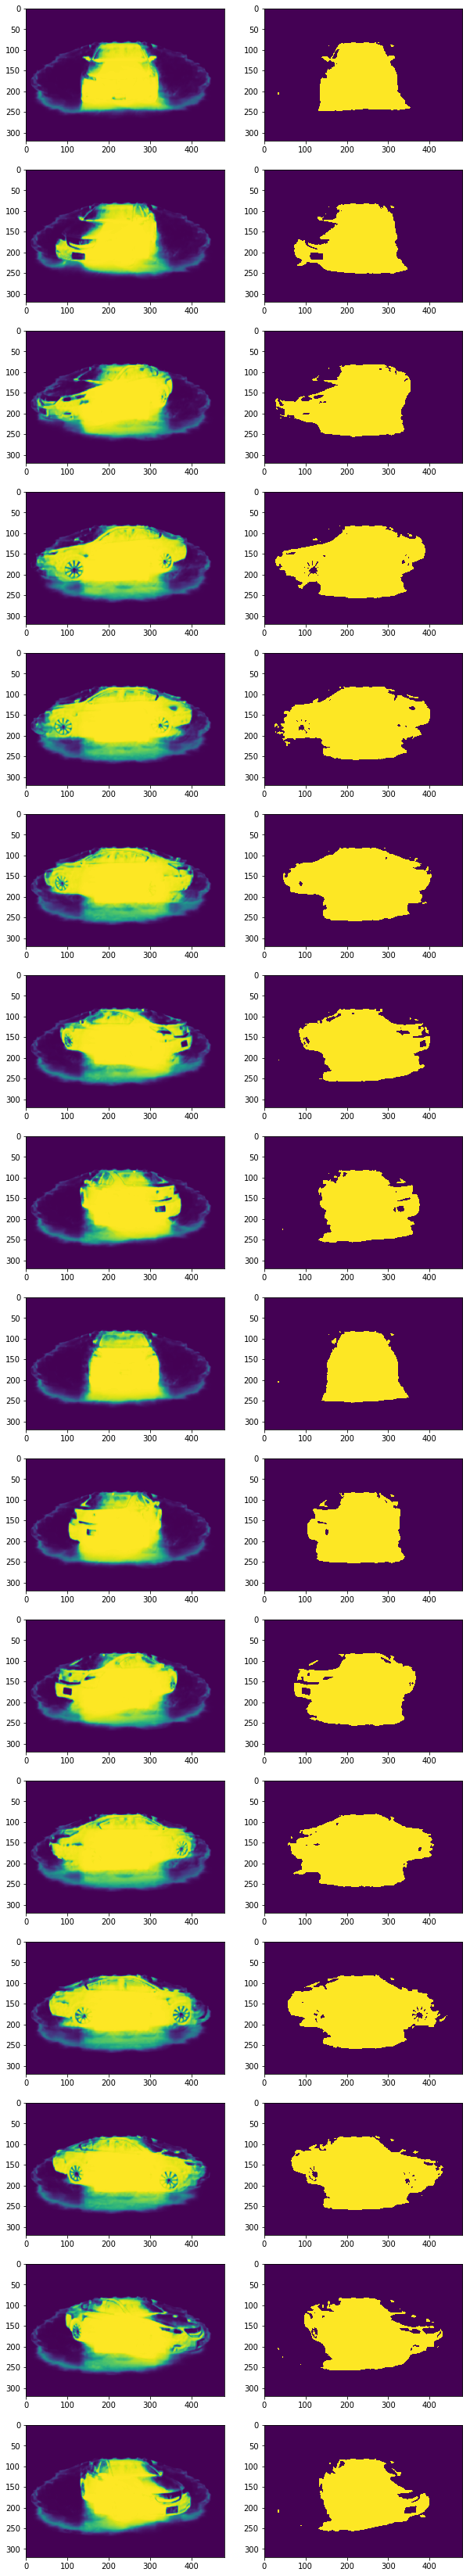

In [230]:
fig, ax = plt.subplots(16,2, figsize=(10, 60))
ax = ax.ravel()

for i in range(16):

    ax[2*i].imshow(y_pred[i])
    ax[2*i+1].imshow(np.where(y_pred[i] > 0.5, 1, 0))

In [232]:
file = open("naive_submission.csv", "w+")
file.write("img,  rle_mask\n")

num_test = 100

with tqdm_notebook(total=num_test) as bar:

    for i in ids_test[:num_test]:
        res = predict_img(prepare_img(i))
        for n, j in enumerate(imgs_idx):
            file.write('{}_{:02d}.jpg, {}\n'.format(i, j, res[n]))
            
        bar.update()

KeyboardInterrupt: 

In [ ]:
def encode_run_length(img):
    h, w = img.shape
    encoding = []
    for r in img:
        run = []
        is_car = False
        for i, p in enumerate(r):
            if p > 0.5:
                if is_car:
                    pass
                else: 
                    is_car = True
                    run.append(i)
            else:
                if is_car:
                    is_car = False
                    run.append(i)
                else:
                    pass
        # Final row
        if is_car:
            run.append(w)
            
        
                 